# General Equilibrium

- So far, we have solved the household’s problem by treating prices (wage and interest rates) as given.  
<br>
- In general equilibrium (GE), these prices are determined endogenously.  
    - s.t. Demand = Supply. Introducing a firm as an agent that demands inputs for production.
<br>
- Similarly, some of the government-related variables, such as tax rates, are also endogenously determined.  
<br>
- Why/when do we care about GE? To capture interaction btw. household behavior and macro variables.  
<br>
    - How much would the tax rate need to increase to finance a given policy (e.g., public pensions or family benefits)?  
    <br>
    - What would happen if the supply of college-educated workers increased due to more generous education subsidies? Would the skill premium rise or fall? And how would changes in the skill premium affect students’ education choices?  
<br>
- After today’s lecture: We will be able to solve a GE model with households, firms, and a government, in which factor prices and the tax rate are endogenously determined.  
---

### Setup

There are three sectors in the model:  
<br>
- Household  
<br>
- Firm  
<br>
- Government  

For notational convenience, we focus on a **stationary economy** and define a **stationary equilibrium**.

---

### Household

Households in this economy are similar to those discussed in the previous section, except that we now allow for **endogenous labor supply**, **public pensions**, and **labor income taxation**.  

- The economy is populated by overlapping generations.  
<br>
- A cohort of households enters the economy at age 20 ($j = 1$) in each period. These households are born without assets and live up to age 80 ($j = J = 61$). Each period, households derive utility from consumption $c_j$ and leisure $l_j$, and discount future utility by the factor $\beta$.  
<br>
- Each period, households choose how much to consume and save. Households are not allowed to borrow. Assets earn an interest rate $r$.  
<br>
- Until age 65 ($j = J_R = 46$), they also decide how many hours to work in the labor market, denoted by $h_j$. They earn gross labor income of $wh_j$, where $w$ is the market wage.  
<br>
- The time endowment is normalized to 1 and is allocated between work $(h_j)$ and leisure $(1 - h_j)$. Labor income is taxed at rate $\tau_w$.  
<br>
- After age $J_R$, households retire and receive a public pension benefit $p = \theta w$, where $\theta \in [0,1]$ is a parameter that governs the generosity of pension benefits.  
<br>
- $\mu(j)$ denotes the measure of households of age $j$, normalized such that $\sum_{j=1}^{J} \mu(j) = 1$.  
<br>
- If we assume no population growth, the mass of each generation is constant: $\mu(j) = \mu(j')$ for any $j, j'$.  

The problem is given by:

\begin{align*}
    & \max_{\{c_j\}_{j=1}^J, \{h_j\}_{j=1}^{J_R}, \{a_{j+1}\}_{j=1}^{J-1}} \sum_{j=1}^J \beta^{j-1} u(c_j, 1 - h_j) \\
    \text{s.t.} \quad
    c_j &= 
    \begin{cases}
        (1 - \tau_w) w h_j + (1 + r) a_j - a_{j+1} & \text{if } j \le J_R \\
        (1 + r) a_j - a_{j+1} + p & \text{if } j \in \{J_R+1, \dots, J-1\} \\
        (1 + r) a_j + p & \text{if } j = J
    \end{cases} \\
    & h_j \in [0, 1), \quad a_1 = 0, \quad a_{j+1} \ge 0, \quad c_j,l_j>0, \quad \forall j
\end{align*}

---

### Firm

- A representative firm that produces final goods $Y$ using the production function:  
$$
F(K, H) = K^\alpha H^{1 - \alpha},
$$
- $K$ and $H$ represent capital and labor inputs.  
<br>
- $\alpha$ governs capital's share in output.  
<br>
- Capital depreciates at rate $\delta$, and the firm bears this depreciation cost.

---

### Government

- The government provides public pensions to retirees, $p=\theta w$.  
<br>
- Finances these benefits by taxing labor income at rate $\tau_w$.  
---

## Stationary Equilibrium

We focus on a **stationary equilibrium**, in which aggregate variables — such as prices and the tax rate — are constant over time. The definition is as follows:

### **Definition (Stationary Equilibrium)**

Given $\theta$, a **stationary equilibrium** consists of household decision rules for consumption, savings, and labor supply $(c(j), a'(j), h(j))$, aggregate quantities $(K, H)$, prices $(r, w)$, and a tax rate $(\tau_w)$, such that:

1. **Household optimization**:  
   Households maximize their lifetime utility by solving the dynamic problem described above.

2. **Firm profit maximization**:  
   The firm’s first-order conditions are satisfied:
   $$
   r = \alpha \left( \frac{K}{H} \right)^{\alpha - 1} - \delta
   $$
   $$
   w = (1-\alpha) \left( \frac{K}{H} \right)^{\alpha}
   $$

3. **Factor market clearing**:
   $$
   K = \sum_{j=1}^{J} a(j) \mu(j)
   $$
   $$
   H = \sum_{j=1}^{J_R} h(j) \mu(j)
   $$

4. **Government budget constraint**:
   The labor tax rate balances the government budget:
   $$
   \tau_w w H = w \theta \underbrace{\sum_{j=J_R+1}^{J} \mu(j)}_{\equiv O}
   $$
   which implies:
   $$
   \tau_w = \theta \cdot \frac{O}{H}
   $$

---

### Algorithm

To solve the general equilibrium numerically, we work with two loops:  
- **Outer loop** for checking if markets are clear with given prices  
<br>
- **Inner loop** for solving household's problem and deriving factor supply

0. Make initial guesses for the tax rate $\tau_w$ and for factor prices $(r,w)$.  
<br>
1. (Inner loop) Solve the household problem and obtain household's decision rules given these prices and tax rate.  
<br>
2. Based on the household decision rules, compute the implied quantities, prices, and tax rate.  
<br>
3. (Outer loop) If these implied prices and tax rate are not close enough to their guesses, update their guesses and return to the step 2 (Inner loop).  
---

### Procedure: basic idea

1. Prepare a function named `solve_lifecycle` that returns household policy functions for savings and labor supply, taking as inputs the prices and tax rate, $(r,w,\tau_w)$. You may set the number of grid points for asset as 200.  
<br>
2. Make initial guess for the tax rate and factor prices $(r,w)$.  You may start with initial guesses like $r=0.05$, $w=1.0$, and $\tau_w=0.1$.  
<br>
3. Using `solve_lifecycle`, go through Steps 2 and 3. You may check if  
    - $|r_g - r_m|/r_g < \varepsilon$  
    - $|w_g - w_m|/w_g < \varepsilon$  
    - $|\tau_{w,g} - \tau_{w,m}|/\tau_{w,g} < \varepsilon$, 
 by setting a convergence criteria $\varepsilon$ to $1.e-2$. Variables with subscript $g$ and $m$ refer to guessed values and model-implied ones.  
 <br>

For parameters, you may set:
- $\beta=0.98$  
- $\sigma=2.0$  
- $\omega=0.5$  
- $\theta=0.3$  
- $\alpha=0.33$  
- $\delta=0.1$

---

### A useful programming tip: `struct`

- (Quantitative) Model is usually complicated (e.g., involving many parameters and many procedures such as solving household problems, general equilibrium, calibration, etc.).  
<br>
- The best practice is to divide the procedures into separate scripts or functions (e.g., one that solves the household problem and another that solves the general equilibrium). This makes the code more readable and less error-prone.  
<br>
- But then, how should we handle the parameters?  
    - Define and assign parameter values in each file?  
    - Use global variables?  
<br>
- Using a `struct` is the typical way to deal with this.

In [12]:

# Basic formula
struct Parameters # Parameters is the name I set. Could be anything.
    β::Float64
    σ::Float64
    ω::Float64
    θ::Float64
    α::Float64
    δ::Float64
    J::Int
    JR::Int
    muj::Vector{Float64}   # 1 here refers to dimension of array
end

# Alternative way
# struct Parameters1{I<:Integer, F<:AbstractFloat} # Params is the name I set. Could be anything.
#     β::F
#     σ::F
#     ω::F
#     θ::F
#     α::F
#     δ::F
#     J::I
#     JR::I
#     muj::Vector{F}
# end

β=0.98
σ=2.0
ω=0.5
θ=0.3
α=0.33
δ=0.1
J=61
JR=46
muj=fill(1.0/J, J)
p = Parameters(β, σ, ω, θ, α, δ, J, JR, muj) # order matters here!
# @show p.β

# # Alternative way:
# # Set default struct Params ("definition of parameters to accept" = the return value, what this function does)
# Parameters1(; β=0.98, σ=2.0, ω=0.5, θ=0.3, α=0.33, δ=0.1, J=61, JR=46, muj=fill(1.0/J, J)) = Parameters1(β, σ, ω, θ, J, JR, muj)
# p = Parameters1()
# @show p.β
# # without this, you have to call Params like p = Params(β, σ, ω, θ, α, δ, J, JR, muj). ie., you should provide all the arguments with exact order.
# # with this default, you could simply state: p = Params() to store the parameter structure in p.
# # if you want to change some parameter value, you can simply write like p = Params(β=0.95), without re-stating all the other (irrelevant) parameters.
# # The leading ; tells Julia that they are keyword arguments, where order does not matter (≠ positional arguments)
# # if you want to use β, you need to type p.β


Parameters(0.98, 2.0, 0.5, 0.3, 0.33, 0.1, 61, 46, [0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082  …  0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082, 0.01639344262295082])

In [13]:
# set household optimization routine.
function solve_lifecycle(r,w,τ,p)
    
    ### inputs ###
    # r: interest rate
    # w: wage rate
    # τ: labor income tax rate 
    # p: struct, p = Parameters(β, σ, ω, θ, α, δ, J, JR, muj)
    ###############

    # discretization for asset space
    mina = 0.0 # lower bound (close to zero but not exactly (to avoid c=0))
    maxa = 10.0  # upper bound
    na   = 1000  # number of grid
    grida = collect(LinRange(mina,maxa,na)); # construct discretized asset space

    # value function and policy functions
    V = zeros(na,p.J); # value function V(a,j)
    Va = zeros(na);  # vector for grid search
    apol = zeros(na,p.J); # policy function for saving (value) a(a,J)
    apol_arg = ones(Int,na,p.J); # policy function for saving (index over asset space, grida)
    cpol = zeros(na,p.J)  # policy function for consumption c(a,J)
    hpol = zeros(na,p.J) # policy function for labor 

    penalty=-1.e+8

    # step 4: solving household problem by backward induction
    for jc in p.J:-1:1 # solve backward
        
        acc_start = 1 # for speed up
        v0=penalty

        for ac in 1:na

            if (jc==p.J) # compute final consumption given a
                c = (1.0+r)*grida[ac]+w*p.θ
                if (c>0)
                    V[ac,jc]=((c^p.ω)^(1.0-p.σ))/(1.0-p.σ) # leisure=1
                else # "punish" c<=0
                    V[ac,jc]=penalty
                end

                cpol[ac,jc]=c; # store it in policy function for c
                hpol[ac,jc]=0.0; # no work in retirement period
                
            else # working or retirement period (except for the final period)

                for acc in acc_start:na

                    # difference btw. working and retirement age; labor income, pension, and labor supply choice.
                    if (jc<=p.JR)
                        A = (1.0+r)*grida[ac]-grida[acc]
                        ATW = (1-τ)*w # AfterTaxWage
                        l = (1.0-p.ω) * (1.0 + A/ATW)
                        pension = 0.0
                    else # if (jc>JR && jc<J), retirement period
                        l = 1.0
                        pension = w*p.θ
                    end

                    c = (1-τ)*w*(1-l) + (1+r)*grida[ac]-grida[acc] + pension

                    if (c>0 && l>0)
                        Va[acc] = ((c^p.ω * l^(1.0-p.ω))^(1.0-p.σ))/(1.0-p.σ) + p.β*V[acc,jc+1]
                    else
                        Va[acc] = penalty
                    end

                    if (Va[acc]>v0)
                        v0=Va[acc]
                        acc_start=acc
                    else
                        break
                    end

                end

                arg = acc_start
                # arg = argmax(Va) # you may also use this instead

                apol_arg[ac,jc]=arg
                apol[ac,jc] = grida[arg]
                V[ac,jc] = Va[arg]

                if (jc<=JR) # working period
                    A = (1.0+r)*grida[ac]-grida[arg]
                    ATW = (1-τ)*w # AfterTaxWage
                    l = (1.0-p.ω) * (1.0 + A/ATW)
                    pension = 0.0
                else # if (jc>JR && jc<J), retirement period
                    l = 1.0
                    pension = w*p.θ
                end

                cpol[ac,jc]=(1.0-τ)*w*(1.0-l) + (1.0+r)*grida[ac]-grida[arg] + pension;
                hpol[ac,jc]=1.0-l
                
            end
        end
    end

    # find asset profile aj
    aj = zeros(p.J);
    hj = zeros(p.J);
    cj = zeros(p.J);

    arg_previous=1;
    aj[1]=grida[arg_previous]; # start from no-asset
    hj[1]=hpol[arg_previous,1]
    cj[1]=cpol[arg_previous,1]
    
    for jc in 2:p.J
        # find today's asset position
        arg = apol_arg[arg_previous,jc-1];
        # choices
        aj[jc]=grida[arg];
        hj[jc]=hpol[arg,jc]
        cj[jc]=cpol[arg,jc]

        arg_previous=arg # update
    end

    return aj,hj,cj # outputs
    
end

solve_lifecycle (generic function with 1 method)

In [15]:
# SOLVE GE
using Printf

# step 1. Make initial guesses
r = 0.02; w = 1.0; τ = 0.1;

K = 1.0; H = 1.0; # to store the equilibrium outcomes later.

# convergence criteria and initial values for dif
ε =[1.e-3, 1.e-3, 1.e-3]; # for (r,w,τ)
d =[1.0, 1.0, 1.0]; # for (r,w,τ)

iter=1;
max_iter=100; # for when something is wrong.

# (optional) to visualize how it converges
r_iter   = zeros(max_iter)
w_iter   = zeros(max_iter)
τ_iter   = zeros(max_iter)

while any(d .> ε)

    # step 2. Household problems
    aj,hj,cj = solve_lifecycle(r,w,τ,p)

    # step 3. Compute the implied aggregate variables and prices
    imp_K = sum(aj.*p.muj)
    imp_H = sum(hj.*p.muj)
    imp_τ = p.θ*sum(p.muj[p.JR+1:p.J])/imp_H

    # compute the implied prices with implied quantities (imp_K,imp_H)
    imp_r = p.α*(imp_K/imp_H)^(p.α-1.0) - p.δ
    imp_w = (1-p.α)*(imp_K/imp_H)^p.α

    # (optional) to visualize how they converge
    r_iter[iter]=r
    w_iter[iter]=w
    τ_iter[iter]=τ

    # step 4. Check if the guesses are right. If not, update.
    dif_r = abs(r-imp_r)/r
    dif_w = abs(w-imp_w)/w
    dif_τ = abs(τ-imp_τ)/τ

    d .= [dif_r,dif_w,dif_τ];

    # Update guess (a linear combination of guessed and implied values)
    adj=0.1; # ADJustment factor (weight)
    r = imp_r*adj + r*(1.0-adj)
    w = imp_w*adj + w*(1.0-adj)
    τ = imp_τ*adj + τ*(1.0-adj)

    K = imp_K; H = imp_H; # store the results

    # @show iter
    # @show maximum(d)

    iter+=1;

    if (iter>max_iter)
        break
    end

end
@show iter
@printf("dif_r = %.5f\ndif_w = %.5f\ndif_t = %.5f\n", d...)
@printf("K = %.5f\nH = %.5f\nr = %.5f\nw = %.5f\nτ = %.5f\n", K, H, r, w, τ)

iter = 62
dif_r = 0.00008
dif_w = 0.00000
dif_t = 0.00099
K = 1.40321
H = 0.36820
r = 0.03465
w = 1.04188
τ = 0.20018


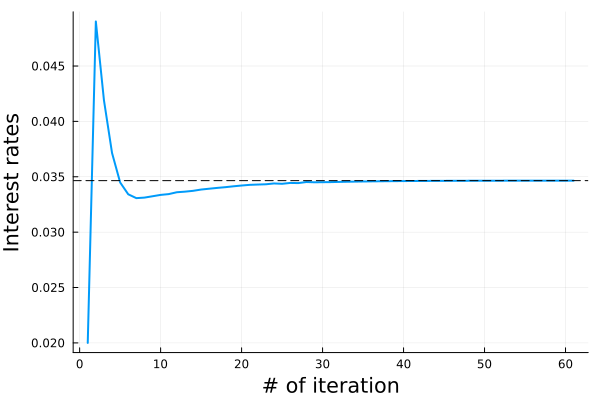

In [16]:
# plot interest rate convergence
using Plots
plot(1:iter-1, r_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel="Interest rates",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))
hline!([r], lw=1, lc=:black, ls=:dash, label="")  # horizontal line at y=r

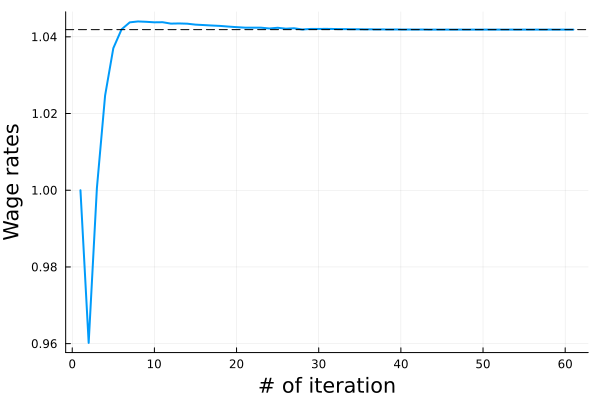

In [17]:
# plot wage rate convergence
plot(1:iter-1, w_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel="Wage rates",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))
hline!([w], lw=1, lc=:black, ls=:dash, label="")  # horizontal line at y=r

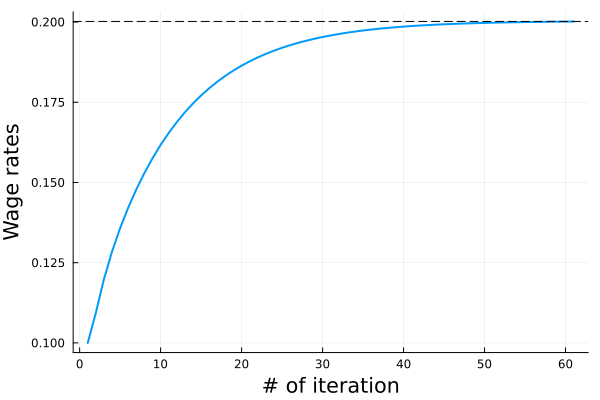

In [18]:
# plot tax rate convergence
plot(1:iter-1, τ_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel="Wage rates",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))
hline!([τ], lw=1, lc=:black, ls=:dash, label="")  # horizontal line at y=r